In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import pandas as pd

In [2]:
import tensorflow as tf
import numpy as np


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(self, sequence_length, num_classes, vocab_size,
                 embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),name="W") 
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
#             losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)

            class_weight = tf.constant([1.0, 100.0])
            weights = tf.reduce_sum(class_weight * self.input_y, axis=1)
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            weighted_losses = losses * weights
#             losses = tf.nn.softmax(tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=-1000))
            self.loss = tf.reduce_mean(weighted_losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
            _, self.precision = tf.metrics.precision(labels=tf.argmax(self.input_y, 1), predictions=self.predictions, name='precision')
            _, self.recall = tf.metrics.recall(labels=tf.argmax(self.input_y, 1), predictions=self.predictions, name='recall')
            
            

In [3]:
import numpy as np
import re
import itertools
from collections import Counter
import pickle

pathway_to_genes_dict = pickle.load(open( "data/pathway_to_genes_dict.p", "rb" ))

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels():
    x_text = sentence_support_df.tokenizedSentenceFromPaper.as_matrix()
    y = sentence_support_df.label.as_matrix()
    y = [[0, 1] if x == 1 else [1, 0] for x in y  ]
    return [x_text, np.array(y)]

def compute_pathway_name_terms(pathway):
    pathway = pathway.replace('signaling', '').replace('pathway', '').replace('-', ' ')
    return [t for t in pathway.lower().strip().split() if len(t)>1]

def tokenize_pathway_names(sentence, pathwayA, pathwayB):
    genesA = [gene.lower() for gene in pathway_to_genes_dict[pathwayA]] + compute_pathway_name_terms(pathwayA)
    genesB = [gene.lower() for gene in pathway_to_genes_dict[pathwayB]] + compute_pathway_name_terms(pathwayB)
    tokenized_sentence = []
    for word in sentence.lower().split():
        token = None
        for gene in genesA:
            if gene in word:
                token = 'pathwayA'
                break
                
        for gene in genesB:
            if gene in word:
                token = 'pathwayB'
                break
        if token is None:
            token = word
        tokenized_sentence.append(token)
    return ' '.join(tokenized_sentence)

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

sentence_support_df = pd.read_csv('data/sentence_support_v3.tsv', delimiter='\t')
sentence_support_df.drop_duplicates(inplace=True)
sentence_support_df['tokenizedSentenceFromPaper'] = sentence_support_df.apply(lambda x: tokenize_pathway_names(x.sentenceFromPaper, x.pathwayA, x.pathwayB), axis=1)

In [4]:
#! /usr/bin/env python

# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .25, "Percentage of the training data to use for validation")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


# Data Preparation
# ==================================================


Parameters:
ALLOW_SOFT_PLACEMENT=True
BATCH_SIZE=64
CHECKPOINT_EVERY=100
DEV_SAMPLE_PERCENTAGE=0.25
DROPOUT_KEEP_PROB=0.5
EMBEDDING_DIM=128
EVALUATE_EVERY=100
FILTER_SIZES=3,4,5
L2_REG_LAMBDA=0.0
LOG_DEVICE_PLACEMENT=False
NUM_CHECKPOINTS=5
NUM_EPOCHS=200
NUM_FILTERS=128



In [5]:
# Load data
print("Loading data...")
x_text, y = load_data_and_labels()

Loading data...


In [6]:
# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# Split train/test set
# TODO: This is very crude, should use cross-validation
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 33447
Train/Dev split: 31796/10598


In [ ]:
np.save(os.path.join(out_dir, 'x_train.npy'), x_train)
np.save(os.path.join(out_dir, 'x_dev.npy'), x_dev)
np.save(os.path.join(out_dir, 'y_train.npy'), y_train)
np.save(os.path.join(out_dir, 'y_dev.npy'), y_dev)

In [7]:
# Training
# ==================================================

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)
        precision_summary = tf.summary.scalar("precision", cnn.precision)
        recall_summary = tf.summary.scalar("recall", cnn.recall)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, precision_summary, recall_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary, precision_summary, recall_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy, precision, recall = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy, cnn.precision, cnn.recall],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}, prec {:g}, recall {:g}".format(time_str, step, loss, accuracy, precision, recall))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy,  precision, recall  = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.precision, cnn.recall],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}, prec {:g}, recall {:g}".format(time_str, step, loss, accuracy, precision, recall))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 

KeyboardInterrupt: 

In [18]:
feed_dict = {
              cnn.input_x: x_dev,
              cnn.input_y: y_dev,
              cnn.dropout_keep_prob: 1.0
            }
predictions = sess.run([cnn.predictions], feed_dict)

In [53]:
df = pd.DataFrame({'pred': np.array(predictions[0])})

In [54]:
df['x'] = pd.Series(np.array(list(vocab_processor.reverse(x_dev))))

In [55]:
df['actual'] = pd.Series(np.argmax(y_dev, 1))

In [79]:
df = df[['x', 'pred', 'actual']]
df.to_csv(os.path.join(out_dir, 'predictions.csv'), index=False)

In [80]:
sess.graph.get_operations()

[<tf.Operation 'input_x' type=Placeholder>,
 <tf.Operation 'input_y' type=Placeholder>,
 <tf.Operation 'dropout_keep_prob' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'embedding/random_uniform/shape' type=Const>,
 <tf.Operation 'embedding/random_uniform/min' type=Const>,
 <tf.Operation 'embedding/random_uniform/max' type=Const>,
 <tf.Operation 'embedding/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'embedding/random_uniform/sub' type=Sub>,
 <tf.Operation 'embedding/random_uniform/mul' type=Mul>,
 <tf.Operation 'embedding/random_uniform' type=Add>,
 <tf.Operation 'embedding/W' type=VariableV2>,
 <tf.Operation 'embedding/W/Assign' type=Assign>,
 <tf.Operation 'embedding/W/read' type=Identity>,
 <tf.Operation 'embedding/embedding_lookup' type=Gather>,
 <tf.Operation 'embedding/ExpandDims/dim' type=Const>,
 <tf.Operation 'embedding/ExpandDims' type=ExpandDims>,
 <tf.Operation 'conv-maxpool-3/truncated_normal/shape' type=Const>,
 <tf.Operation 

In [250]:
temp = sess.run(sess.graph.get_tensor_by_name('conv-maxpool-3/conv:0'), feed_dict = {
              cnn.input_x: x_dev[:2],
              cnn.input_y: y_dev[:2],
              cnn.dropout_keep_prob: 1.0
            })
temp1 = np.sum(temp.reshape([temp.shape[0], temp.shape[1], temp.shape[-1]]), axis=2)/temp.shape[-1]
temp1.shape

(2, 271)

In [398]:
def cnn_activation(conv_layer=3):
    temp = sess.run(sess.graph.get_tensor_by_name('conv-maxpool-%s/conv:0' % conv_layer), feed_dict = {
              cnn.input_x: x_dev[:10],
              cnn.input_y: y_dev[:10],
              cnn.dropout_keep_prob: 1.0
            })
    temp1 = np.sum(temp.reshape([temp.shape[0], temp.shape[1], temp.shape[-1]]), axis=2)/temp.shape[-1]
    wmin = np.min(temp1, axis=1)
    wmax = np.max(temp1, axis=1)
    temp2 = (temp1.transpose() - wmin)/(wmax-wmin)
    temp2 = temp2.transpose()
    temp3 = np.zeros([temp.shape[0], 273])
    for i in range(temp2.shape[1]):
        temp3[:,i:i+3] += temp2[:,i].reshape([temp.shape[0],1])
#         temp3[:,i] += temp2[:,i]
    temp3 = temp3/conv_layer
    return temp3

In [404]:
temp3 = cnn_activation(conv_layer=3)
temp3.shape

(10, 273)

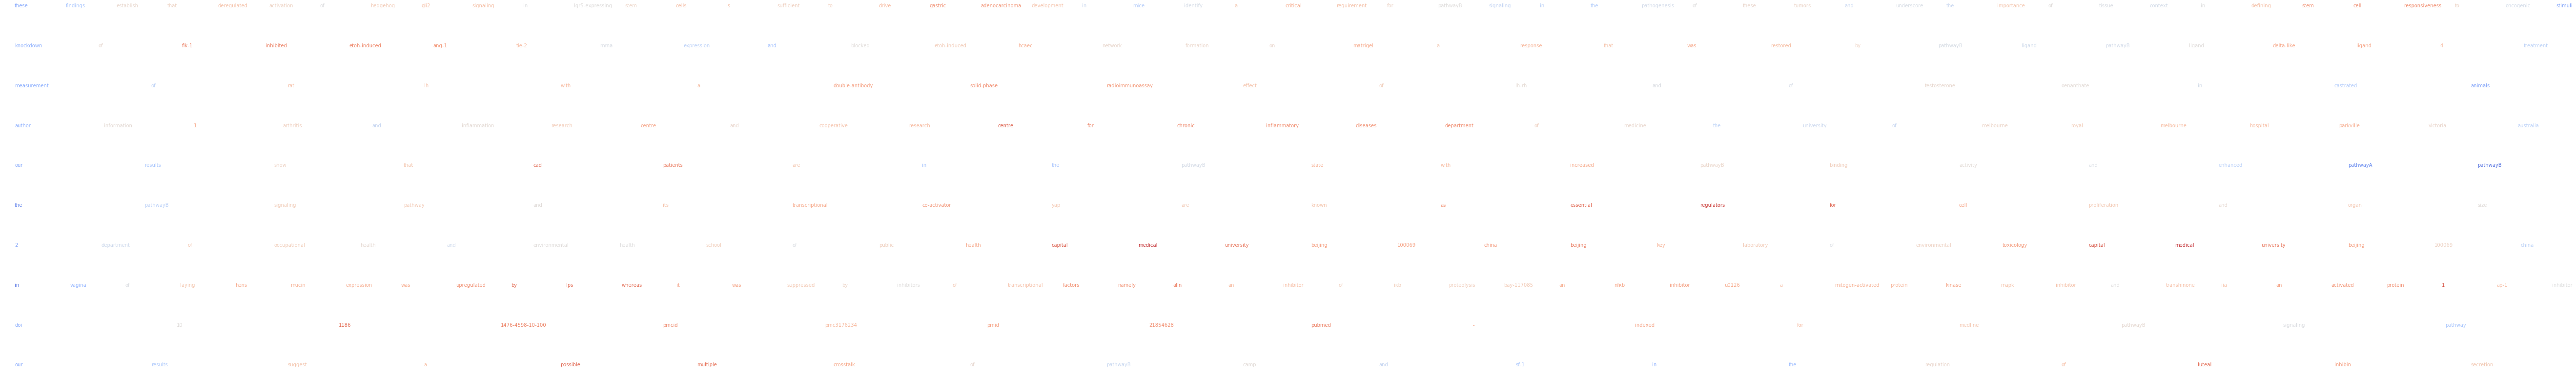

In [406]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

my_cmap = mpl.cm.coolwarm

fig, ax = plt.subplots()
for j in range(len(dev_input[:10])):
    words = dev_input[j].split('<UNK>')[0].split()
    for i in range(len(words)):
        num_words = len(words)
        ax.text(i/num_words*14, j/3, words[i], color=my_cmap(temp3[j][i]), zorder=0)
# For the moment, hide everything else...
ax.axis('off')
fig.tight_layout()